In [248]:
import scipy.io as sio
from scipy.io import readsav
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import fits

from residual_plot import residual_plot

In [267]:
star_name = '101501'#'26965'#'101501'
file_end = "best_fit"#"best_fit" #"prov_rvs"#or 

hdul_open = fits.open('HD'+star_name+'/binned_ccfs/binned_ccfs_'+file_end+'.fits', memmap=False)
wls = hdul_open[1].data['wls']
ccf_list = hdul_open[1].data['binned_ccfs']#[8:]
ccf_list = ccf_list - np.median(ccf_list, axis=0)
median_residual = np.median(ccf_list, axis=0)
std_residual = np.std(ccf_list, axis=0)
rescaled_resids = (ccf_list-median_residual)/std_residual

bjd_list = hdul_open[2].data['bjd']#[8:]

if file_end =="best_fit":
    rv_list = hdul_open[2].data['mu_og_list']
else:
    rv_list = hdul_open[2].data['vrad_star']

#rv_list = hdul_open[2].data['vrad_star']# hdul_open[2].data['mu_og_list'] # [8:] #hdul_open[2].data['mu_og_list'][8:] #
rv_error = hdul_open[2].data['svrad_star']#[8:]

# create pandas dataframe
df = pd.DataFrame(list(zip(bjd_list, rv_list, rv_error, rescaled_resids)), columns=["BJD","vrad", "svrad", "CCF"])
df_sorted = df.sort_values(by=['BJD']) 

In [268]:
# format data for LS fit
rv_np = np.array(list(df_sorted["vrad"]-np.mean(df_sorted["vrad"])))*1000
s_rv_np = np.array(list(df_sorted["svrad"]))*1000
ccf_list_np = np.array(list(df_sorted["CCF"]))
ccf_list_np_transpose = ccf_list_np.transpose()
time_np = np.array(df_sorted["BJD"])-np.min(df_sorted["BJD"])

In [269]:
np.std(hdul_open[2].data['vrad_star'], ddof=1)

0.004698322

In [270]:
wls[0][1]-wls[0][0]

0.09999466

0.0 1.0


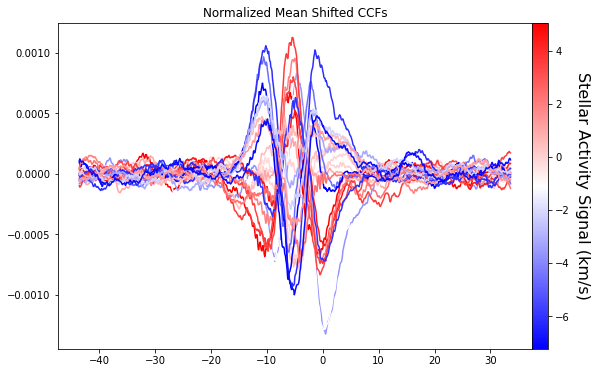

In [271]:
residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")


#plt.vlines(wls[0][ccf_indexes], ymin=-0.00050, ymax=0.00125, color="k")

Text(0, 0.5, 'RV (m/s)')

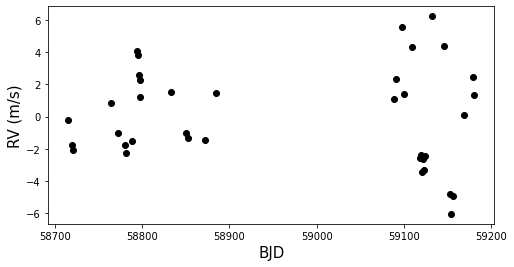

In [254]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))

x = df_sorted["BJD"]
y = rv_np
yerr = df_sorted["svrad"]

#ax[0].scatter(txt_file["BJD_UTC"]-2400000, txt_file["vrad"]-np.mean(txt_file["vrad"]))
ax.errorbar(x, y, yerr = yerr, fmt = 'o', color='k')
ax.set_xlabel("BJD", size=15)
ax.set_ylabel("RV (m/s)",size=15)


In [108]:
# Loss function

Loss = new_rms + np.abs(a_coeff)**2

In [258]:
# Genetic Algorithm to find the optimal ccf params

possible_indexes = np.arange(280, 423)#np.arange(0, len(ccf_list_np[0])-1)
ccf_indexes =  [290, 340, 355, 389]#[340, 355, 370, 358]#, 368, 401, 500, 600]
best_indexes =  [290, 340, 355, 389]#[340, 355, 370, 358]#, 368, 401, 500, 600]
best_rms = np.std(y, ddof=1) #m/s

print(str(round(best_rms,3))+", og indexes: "+str(best_indexes))

jumps = 0
while jumps <100000:
    # Choose the random index to replace in the ccf
    rand_index = np.random.randint(0, len(ccf_indexes))
    # Choose what index to replace it with
    new_ccf_loc = np.random.choice(possible_indexes)
    
    # check whether this index already exists in the array. If it does, it assigns a new one until it does not exist in the array anymore
    while new_ccf_loc in ccf_indexes:
        new_ccf_loc = np.random.choice(possible_indexes)
    #print(str(rand_index)+", "+str(new_ccf_loc))
    
    # replace it
    ccf_indexes[rand_index] = new_ccf_loc
    
    # perform the L-S fit --------------
    n_cols =len(ccf_indexes)+1
    n_rows = len(ccf_list_np) # len(ccf_list_np)<---- unsmoothed
    x = np.zeros((n_rows, n_cols))
    
    x[:,0] =  1
    for i in np.arange(0, len(ccf_indexes)):
        x[:,i+1] = ccf_list_np_transpose[ccf_indexes[i]] #(for all observations)
    y = rv_np
    
    alpha = x.transpose().dot(x)
    beta = x.transpose().dot(y)
    

    # and finally we can write a_coeff = alpha^-1 * beta
    inv_alpha = np.linalg.inv(alpha)
    a_coeff = inv_alpha.dot(beta)
    
    CCF_matrix = np.zeros((n_rows, len(ccf_indexes)))
    for i in np.arange(0, len(ccf_indexes)):
        CCF_matrix[:,i] = ccf_list_np_transpose[ccf_indexes[i]] #(for all observations)
    
    y_preds = CCF_matrix.dot(a_coeff[1:])+ a_coeff[0]
    
    # Compute the scatter metric
    new_rms = np.std(y-y_preds, ddof=1)
    
    # Evaluate the L-S fit --------------
    jumps +=1
    # check whether the new rms is lower than the previously best rms
    if new_rms < best_rms:
        best_indexes[rand_index] = new_ccf_loc
        best_rms = new_rms
        ccf_indexes = best_indexes.copy()
        #print(", best indexes: "+str(best_indexes))
        print(str(round(new_rms,3))+", best indexes: "+str(best_indexes)+", a_coeff: "+str(a_coeff))
    else: #rms is not lower
        # resets the ccf_indexes back to the previously best ones
        ccf_indexes = best_indexes.copy()
        #print("WORSE: "+str(round(new_rms,3))+", ccf indexes: "+str(ccf_indexes))
        #print(", best indexes: "+str(best_indexes))
        #continue

print(str(round(best_rms,3))+", best indexes: "+str(best_indexes))

3.019, og indexes: [290, 340, 355, 389]
2.887, best indexes: [290, 340, 355, 321], a_coeff: [-0.2661825  -0.74214866 -0.2399562  -0.19624096  0.80931594]
2.705, best indexes: [290, 340, 355, 351], a_coeff: [  0.44772038  -0.40852955  10.66073127  13.39344047 -23.45622867]
2.403, best indexes: [290, 340, 355, 284], a_coeff: [  1.557542   -14.13157635   1.67246858  -1.91081864  13.67809537]
2.242, best indexes: [290, 340, 394, 284], a_coeff: [  1.80474573 -15.23799301   0.71419785   1.6614392   14.00966133]
2.233, best indexes: [290, 340, 414, 284], a_coeff: [  1.89450084 -14.5704202    0.90345318   1.60894597  13.72608623]
2.229, best indexes: [290, 374, 414, 284], a_coeff: [  1.77829457 -16.1222776    0.87303495   0.81126549  14.41905927]
2.216, best indexes: [290, 374, 294, 284], a_coeff: [ 1.11083476 -8.97490945  1.36325247 -5.54244038 12.73806901]
2.213, best indexes: [290, 407, 294, 284], a_coeff: [  1.79988767 -11.29265431   1.01446546  -4.73007296  14.83522417]
2.167, best indexe

In [707]:
#np.argmin(np.abs(wls[0]+20))

323

0.0 1.0


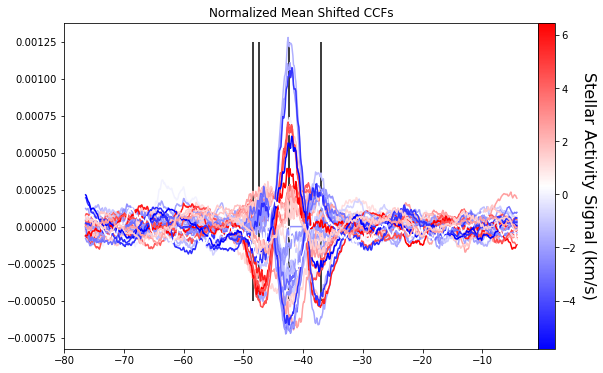

In [265]:
best_indexes = [290, 340, 394, 280]#[345, 379, 391, 403, 413, 440] #[310 , 348, 358, 368, 401]#
#best_indexes = np.array(best_indexes)# -15

residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")
plt.vlines(wls[0][best_indexes], ymin=-0.00050, ymax=0.00125, color="k")

In [243]:
#number of columns
#ccf_indexes = np.random.choice(possible_indexes, 4)
ccf_indexes =  [345, 379, 391, 403, 413, 440]#[310 , 348, 358, 368, 401] #[378, 344, 368, 356]  #[346, 378]#[378, 604, 598, 346, 229]#[310 , 348, 358, 368, 401]
#[80, 230, 310 , 350, 360, 370, 410 ,500 , 620] #another optimization point
ccf_indexes = np.array(ccf_indexes)-15


n_cols =len(ccf_indexes)+1
n_rows = len(ccf_list_np) # len(ccf_list_np)<---- unsmoothed
x = np.zeros((n_rows, n_cols))

# delete this line later
period = 9.978570

x[:,0] =  1
#x[:,1] =  np.sin(2*np.pi*(time_np-T_c)/period+np.pi) #try a whole bunch periods
#x[:,4] =  np.cos(2*np.pi*(time_np-T_c)/period)


# add variables for every position in x per ccf. Each variable has all observations for that position in x
# if choosing random points within x evenly sampled
#ccf_indexes = []
#for i in np.arange(0, 8):
#    x[:,i+1] = ccf_list_np_transpose[89*i] #(for all observations)
#    ccf_indexes.append(55*i)

for i in np.arange(0, len(ccf_indexes)):
    x[:,i+1] = ccf_list_np_transpose[ccf_indexes[i]] #(for all observations)

#Using the smoothed over CCFs
#for i in np.arange(0, len(master_binned_center_CCFs_transpose)):
#    X[:,i+5] = master_binned_center_CCFs_transpose[i]

y = rv_np

0.0 1.0


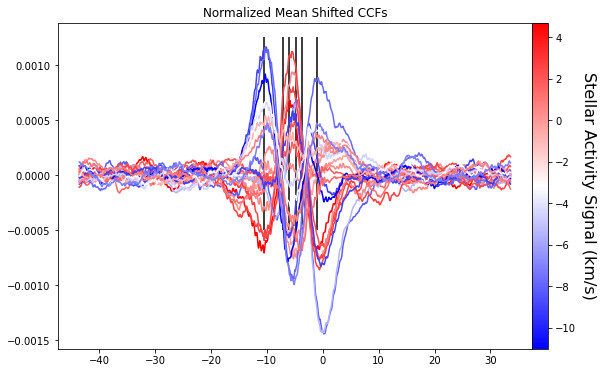

In [244]:
residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")
plt.vlines(wls[0][ccf_indexes], ymin=-0.00050, ymax=0.00125, color="k")

In [245]:
alpha = x.transpose().dot(x)
beta = x.transpose().dot(y)

# and finally we can write a_coeff = alpha^-1 * beta
inv_alpha = np.linalg.inv(alpha)
a_coeff = inv_alpha.dot(beta)

In [246]:
CCF_matrix = np.zeros((n_rows, len(ccf_indexes)))
print(len(ccf_indexes))
for i in np.arange(0, len(ccf_indexes)):
    CCF_matrix[:,i] = ccf_list_np_transpose[ccf_indexes[i]] #(for all observations)

6


2.187938793058303

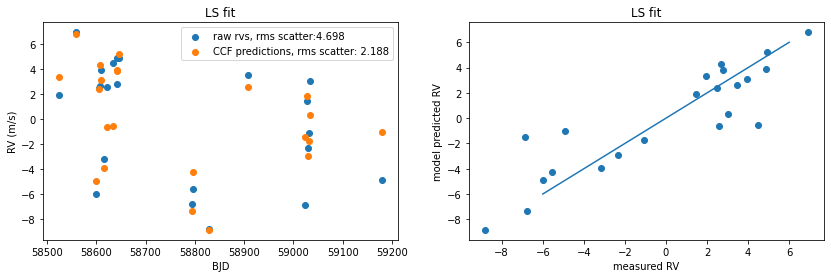

In [247]:
y_preds = CCF_matrix.dot(a_coeff[1:])+ a_coeff[0]


fig, ax = plt.subplots(1,2, figsize=(14, 4))
ax[0].scatter(time_np+np.min(df_sorted["BJD"]),
              y, label="raw rvs, rms scatter:"+str(round(np.std(y, ddof=1),3)))
ax[0].scatter(time_np+np.min(df_sorted["BJD"]),
              y_preds, label="CCF predictions, rms scatter: "+str(round(np.std(y-y_preds,ddof=1),3)))
ax[0].set_ylabel("RV (m/s)")
ax[0].set_xlabel("BJD")
ax[0].set_title("LS fit")
ax[0].legend()

ax[1].scatter(y, y_preds)
ax[1].plot([-6,6],[-6,6])
ax[1].set_xlabel("measured RV")
ax[1].set_ylabel("model predicted RV")
ax[1].set_title("LS fit")


np.std(y-y_preds,ddof=1)

In [609]:
jitterpar = 0

In [619]:
def log_likelihood(theta, t, x, y, e):
    #amplitude, jitterpar, D, a0, a1, a2, a3, a4, a5, a6, a7 = theta
    D, a0, a1, a2, a3, a4  = theta
    #jitterpar, D, a0, a1, a2, a3, a4 = theta
    #model = amplitude * np.sin(2*np.pi*(t-T_c)/period + np.pi) + D + a0*x[:,0] + a1*x[:,1] + a2*x[:,2] + a3*x[:,3] + a4*x[:,4] +a5*x[:,5] + a6*x[:,6] + a7*x[:,7] #+ a8*x[:,8]+ a9*x[:,9] + a10*x[:,10] + a11*x[:,11] +a12*x[:,12]
    model = D + a0*x[:,0] + a1*x[:,1] + a2*x[:,2] + a3*x[:,3] + a4*x[:,4]# +a5*x[:,5] + a6*x[:,6] + a7*x[:,7] +a8*x[:,8]
    sigma2 = e**2 + jitterpar**2
    loglikelihood =  -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
    return loglikelihood

In [620]:
#solnx = np.array([2.20048546e+00])#np.array([0.01e+00,  2.20048546e+00, -7.21531857e-09])
#solnx = np.append(solnx, a_coeff[0])
#solnx = np.append(solnx, a_coeff[1])
#solnx = np.append(solnx, a_coeff[2])
solnx = a_coeff

#num = 0
#for i in np.arange(0, len(a_coeff[0:])): # change back to 4 if you include linear and quadratic
#    solnx = np.append(solnx, a_coeff[1:][i])
#    num +=1



In [621]:
solnx

array([ 0.43907889,  0.94056669, -0.68909727, -1.00252872,  1.33186056,
       -0.01784141])

In [622]:
len(solnx)

6

In [623]:
def log_prior(theta):
    D ,  a0, a1, a2, a3, a4 = theta
    #jitterpar, D , a0, a1, a2, a3, a4 = theta
    #amplitude, jitterpar, D, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = theta
    #if 0.01 < jitterpar < 4.0:
    #    return 0.0
    if 0.1 < D < 5:
        return 0.0
    return -np.inf

In [624]:
def log_probability(theta, t, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, x, y, yerr)

In [625]:
pos = solnx + 1e-4 * np.random.randn(60, len(solnx)) #ball size array for each parameter
#pos[:,3] = pos[:,3]*2.6897657941202826e+14
#pos[:,13] = pos[:,13]*2.6897657941202826e+14
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_np, CCF_matrix, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [05:25<00:00, 15.37it/s]


State([[ 0.62489584  1.03723325 -1.64131044 -0.09908943  1.33893608 -0.28051452]
 [ 0.62493057  1.03725498 -1.64141063 -0.09904583  1.33895607 -0.28052348]
 [ 0.62489937  1.03705217 -1.64157128 -0.09904151  1.33908756 -0.28039857]
 [ 0.62488456  1.03723992 -1.64124339 -0.09937097  1.33904954 -0.28065394]
 [ 0.62492255  1.03731193 -1.64129217 -0.09908416  1.33886699 -0.28063358]
 [ 0.62491942  1.03715892 -1.64123814 -0.09947207  1.33916963 -0.28053597]
 [ 0.624871    1.03718892 -1.64105212 -0.09958874  1.33913658 -0.28055383]
 [ 0.62491304  1.03724994 -1.64151279 -0.09912171  1.33917479 -0.28054142]
 [ 0.62492296  1.03730907 -1.64122242 -0.09933002  1.33904209 -0.28061738]
 [ 0.62486402  1.03714825 -1.64134144 -0.09935265  1.33918858 -0.28052983]
 [ 0.62492665  1.03731233 -1.64157573 -0.09874867  1.33886363 -0.28060892]
 [ 0.62492654  1.03724407 -1.64154315 -0.09896951  1.33900067 -0.28055661]
 [ 0.6248835   1.03734034 -1.64109203 -0.09932646  1.33890101 -0.28067607]
 [ 0.62491504  1.03

Text(0.5, 0, 'step number')

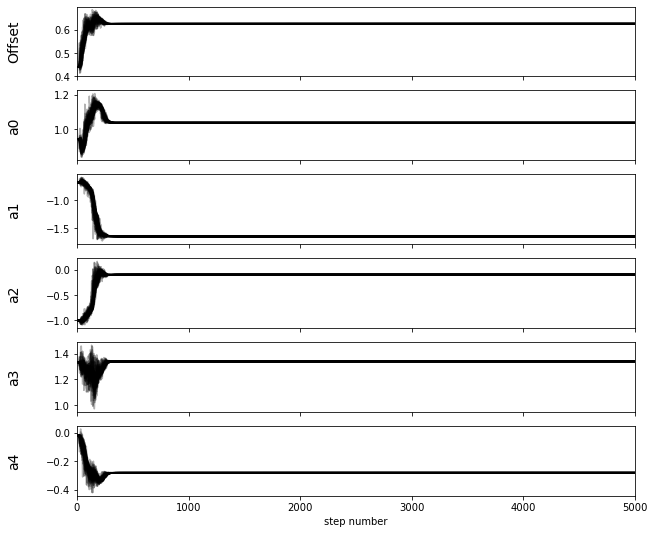

In [626]:
fig, axes = plt.subplots(len(solnx), figsize=(10, 1.5*len(solnx)), sharex=True)
samples = sampler.get_chain()
labels = ["Offset","a0", "a1", "a2", "a3",
          "a4", "a5", "a6", "a7", "a8"]
#["Jitterpar","Offset","a0", "a1", "a2", "a3",
#         "a4", "a5", "a6", "a7", "a8"]
#labels = ["Amplitude", "Jitterpar","Offset", "a0", "a1", "a2", "a3",
#          "a4", "a5", "a6", "a7", "a8", "a9", "a10", "a11", "a12"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], size=14)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [627]:
# discard first 100 burn-in samples
flat_samples = sampler.get_chain(discard=2500, thin=15, flat=True)
print(flat_samples.shape)

(9960, 6)


In [628]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print("LS coeffs: "+str(a_coeff))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

LS coeffs: [ 0.43907889  0.94056669 -0.68909727 -1.00252872  1.33186056 -0.01784141]


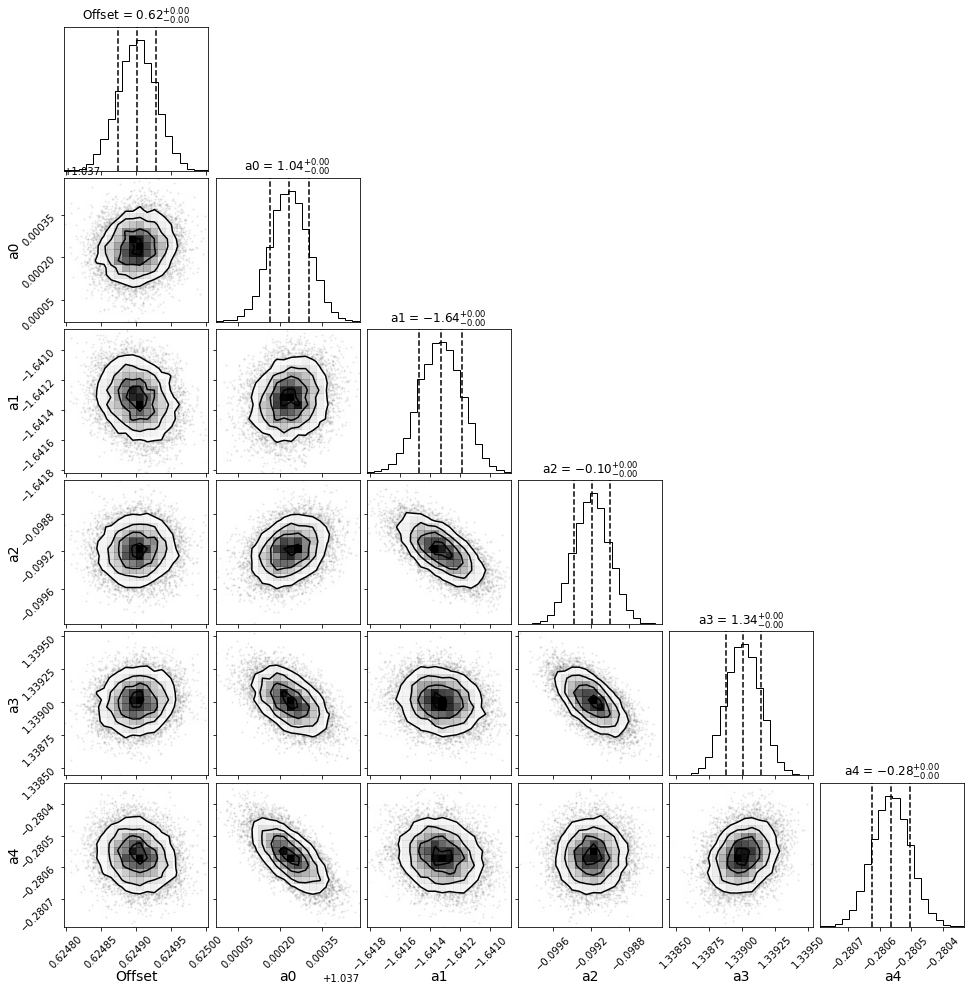

In [629]:
import corner
fig = corner.corner(
    flat_samples,
    labels=labels,
    quantiles=[0.159, 0.5, 0.841],
    show_titles=True,
    label_kwargs=dict(fontsize=14))

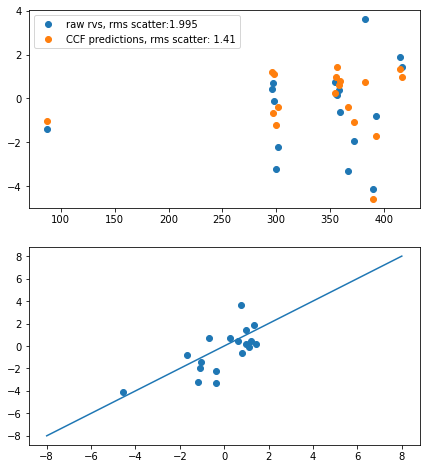

In [630]:
D_mcmc = np.percentile(flat_samples[:, 0], [50])[0]

A_mcmc_coeffs = np.zeros(len(ccf_indexes))
for i in np.arange(1, len(ccf_indexes)+1):
    A_mcmc_coeffs[i-1]=  np.percentile(flat_samples[:, i], [50])[0]

A_mcmc_coeffs
y_preds = D_mcmc + CCF_matrix.dot(A_mcmc_coeffs)

fig, ax = plt.subplots(2,1, figsize=(7, 8))
ax[0].scatter(time_np[8:], y[8:], label="raw rvs, rms scatter:"+str(round(np.std(y, ddof=1),3)))
ax[0].scatter(time_np[8:], y_preds[8:], label="CCF predictions, rms scatter: "+str(round(np.std(y-y_preds,ddof=1),3)))

ax[1].scatter(y_preds[8:], y[8:])
ax[1].plot([-8,8],[-8,8])
ax[0].legend()

In [569]:
# compute log-likelhoods

# mcmc fit
mcmc_log_likelihood = log_likelihood([D_mcmc,A_mcmc_coeffs[0],A_mcmc_coeffs[1]],time_np, CCF_matrix, y, yerr)
print("mcmc_log_likelihood: "+str(mcmc_log_likelihood))


LS_log_likelihood = log_likelihood(a_coeff,time_np, CCF_matrix, y, yerr)
print("LS_log_likelihood: "+str(LS_log_likelihood))

mcmc_log_likelihood: -736561235.347437
LS_log_likelihood: -752243599.1848929


In [337]:
np.std(y-y_preds,ddof=1)

1.6580656067001673

In [338]:
np.std(y, ddof=1)

1.9953064054798533

In [562]:
D_mcmc

1.031739186812164

In [565]:
A_mcmc_coeffs

array([-2.42805751,  1.68200802])